# Mobility for resilience: population density analysis

This notebook shows how to transform raw mobility data to population density maps using `mobilkit`.

We start loading raw HFLB data using the `mobilkit.loader` module.

In [1]:
%config Completer.use_jedi = False
%matplotlib inline

import os
import csv
import gzip
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
import copy
import pickle
from datetime import datetime as dt
from datetime import timedelta
from datetime import timezone
import pytz
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import mpl_toolkits.axes_grid1
import matplotlib.gridspec as gridspec
import mpl_toolkits
import dask
from dask import dataframe as dd
from dask.distributed import Client

import mobilkit

## Load raw pings for selected IDs

In [5]:
# client.close()
client = Client(address="127.0.0.1:8786", )
client.upload_file("dist/mobilkit-0.1-py3.9.egg")

{'tcp://127.0.0.1:44845': {'status': 'OK'},
 'tcp://127.0.0.1:45415': {'status': 'OK'},
 'tcp://127.0.0.1:46085': {'status': 'OK'},
 'tcp://127.0.0.1:46423': {'status': 'OK'}}

In [6]:
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 24.00 GB


In [1]:
alldataf = "results/displacement_selectedids_all_data/"
filtered_dataf_reloaded = dd.read_parquet(alldataf) # .repartition(partition_size="200M")
if "datetime" not in filtered_dataf_reloaded.columns:
    # Add datetime column
    import pytz
    tz = pytz.timezone("America/Mexico_City")
    # Filter on dates...
    filtered_dataf_reloaded = mobilkit.loader.filterStartStopDates(filtered_dataf_reloaded,
                                                    start_date="2017-09-04",
                                                    stop_date="2017-09-25",
                                                    tz=tz,)
    filtered_dataf_reloaded = mobilkit.loader.compute_datetime_col(filtered_dataf_reloaded, selected_tz=tz)

## Compute day- and night-time locations

First I compute all the day and night time, then I use the function to compute the locations of each users for each day during day and night.

---
**NOTE**

When determining the home location of a user, please consider that some data providers, like _Cuebiq_, obfuscate/obscure/alter the coordinates of the points falling near the user's home location in order to preserve privacy.

This means that you cannot locate the precise home of a user with a spatial resolution higher than the one used to obfuscate these data. If you are interested in the census area (or geohash) of the user's home alone and you are using a spatial tessellation with a spatial resolution wider than or equal to the one used to obfuscate the data, then this is of no concern.

However, tasks such as stop-detection or POI visit rate computation may be affected by the noise added to data in the user's home location area. Please check if your data has such noise added and choose the spatial tessellation according to your use case.

---

In [2]:
# Prepare pings adding day- night- stuff 
df_with_dn_time = mobilkit.temporal.filter_daynight_time(
                                                filtered_dataf_reloaded,
                                                filter_from_h=-1,
                                                filter_to_h=25, # To keep all the events
                                                previous_day_until_h=4,
                                                daytime_from_h=8,
                                                daytime_to_h=22,
                                            )

In [9]:
# Filter to ROI
df_with_dn_time_roi = mobilkit.spatial.filter_to_box(df_with_dn_time,
                                                       minlon=-99.8761, maxlat=19.7661,
                                                       maxlon=-97.9208, minlat=18.7507)

In [10]:
# Sample for speedup
df_sampled = df_with_dn_time_roi.sample(frac=.2)

In [3]:
result_density = mobilkit.spatial.compute_population_density(df_sampled, maxpoints=50, max_iter=100)

In [13]:
result_density.to_pickle("results/population_density.pkl")

## Plot density maps

In [14]:
result_density = pd.read_pickle("results/population_density.pkl")

In [15]:
normaldays = [dt.strptime(s, "%Y%m%d") for s in ["20170904","20170905","20170906",
                                                 "20170907","20170908","20170911",
                                                "20170912","20170913","20170914","20170915"]]

In [16]:
# Prepare some annotations, just in case...
map_annotations = {
    "CDMX": dict(xy=(-98.85,19.5), xycoords='data', color="white", fontsize=14),
    "Puebla": dict(xy=(-98.5,18.8), xycoords='data', color="white", fontsize=14), 
    "Toluca": dict(xy=(-99.75,19.5), xycoords='data', color="white", fontsize=14), 
    "Cuernavaca": dict(xy=(-99.4,18.65), xycoords='data', color="white", fontsize=14),
}

### Daytime population density

In [17]:
from importlib import reload
reload(mobilkit)
reload(mobilkit.viz)
reload(mobilkit.spatial)

<module 'mobilkit.spatial' from '/home/ubi/Sandbox/mobilkit_dask/mobilkit/spatial.py'>

In [18]:
df = result_density.reset_index().copy(deep=True)

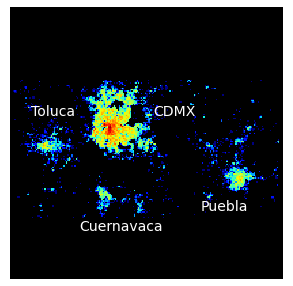

In [19]:
date = dt(2017,9,20)
daytime = True

df = df[(df["date"]==date) & (df["daytime"]==daytime)]

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set_aspect("equal")
heatmap, ax = mobilkit.viz.plot_density_map(df["lat"], df["lng"], (19.3, -98.9), 200, 1, ax,
                                   annotations=map_annotations)

In [20]:
# Select parameters for the analysis
bins = 200
center = (19.3, -98.9)
radius = 1

In [21]:
results_day = mobilkit.spatial.stats_density_map(result_density, normaldays, daytime=True,
                                                         bins=bins, center=center, radius=radius)

results_night = mobilkit.spatial.stats_density_map(result_density, normaldays, daytime=False,
                                                         bins=bins, center=center, radius=radius)

### Standard deviation

/home/ubi/Sandbox/mobilkit_dask/mobilkit/viz.py:100: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  divnorm = mcolors.SymLogNorm(linthresh=1.0, linscale=1.0, vmin=vmin, vmax=vmax)


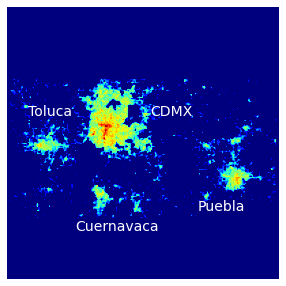

In [22]:
mobilkit.viz.shori_density_map(results_day["std"], results_day["x_bins"], results_day["y_bins"],
                               ax=None, annotations=map_annotations,
                               vmin=1e-4, vmax=results_day["std"].max())

### z-scores

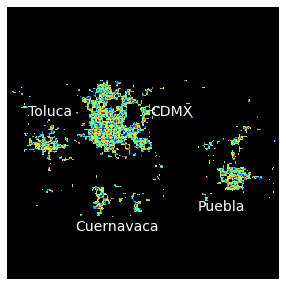

In [23]:
# select the day to plot
mobilkit.viz.shori_density_map(results_day["zsc"][0], results_day["x_bins"], results_day["y_bins"],
                               ax=None, annotations=map_annotations,
                               vmin=-3, vmax=3)

### Compute the zscore in a given day

I just compute the density map for that day and compute its z-score w.r.t. the analysis on the "normal" days.

In [24]:
date_selected = dt(2017, 9, 19)
density_earthquake_d, xybins = mobilkit.spatial.stack_density_map(result_density, dates=[date_selected],
                                                       center=center, bins=bins, radius=radius)

density_earthquake_n, xybins = mobilkit.spatial.stack_density_map(result_density, dates=[date_selected], daytime=False,
                                                       center=center, bins=bins, radius=radius)

In [25]:
z_score_earthq_d = (density_earthquake_d - results_day["avg"]) / results_day["std"]
z_score_earthq_n = (density_earthquake_n - results_night["avg"]) / results_night["std"]

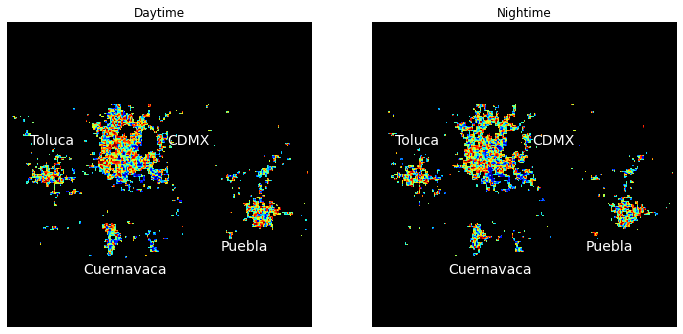

In [26]:
fig, axs = plt.subplots(1,2,figsize=(12,6))

ax = axs[0]
ax.set_title("Daytime")
mobilkit.viz.shori_density_map(z_score_earthq_d[0], results_day["x_bins"], results_day["y_bins"],
                               ax=ax, annotations=map_annotations,
                               vmin=-3, vmax=3)


ax = axs[1]
ax.set_title("Nightime")
mobilkit.viz.shori_density_map(z_score_earthq_n[0], results_day["x_bins"], results_day["y_bins"],
                               ax=ax, annotations=map_annotations,
                               vmin=-3, vmax=3)

### Zoom in CDMX

In [27]:
center = (19.43, -99.13)
radius = .2
bins = int(500*radius)

In [28]:
results_day_mxc = mobilkit.spatial.stats_density_map(result_density, normaldays, daytime=True,
                                                         bins=bins, center=center, radius=radius)

results_night_mxc = mobilkit.spatial.stats_density_map(result_density, normaldays, daytime=False,
                                                         bins=bins, center=center, radius=radius)

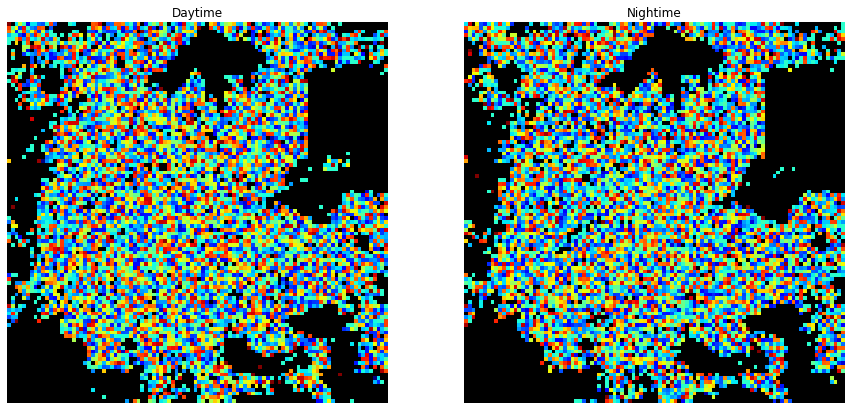

In [29]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(1,2)
ax = fig.add_subplot(gs[0,0])
ax.set_title("Daytime")
mobilkit.viz.shori_density_map(results_day_mxc["zsc"][0], results_day_mxc["x_bins"], results_day_mxc["y_bins"],
                               ax=ax, vmin=-3, vmax=+3)

ax = fig.add_subplot(gs[0,1])
ax.set_title("Nightime")
mobilkit.viz.shori_density_map(results_night_mxc["zsc"][0], results_night_mxc["x_bins"], results_night_mxc["y_bins"],
                               ax=ax, vmin=-3, vmax=+3)

#### Compare day and night

In [30]:
# Compare event day
date_selected = dt(2017, 9, 19)
density_earthquake_mxc_d, xybins_mxc_d = mobilkit.spatial.stack_density_map(result_density, dates=[date_selected],
                                                       center=center, bins=bins, radius=radius)

density_earthquake_mxc_n, xybins_mxc_n = mobilkit.spatial.stack_density_map(result_density, dates=[date_selected],
                                                                            daytime=False, 
                                                                            center=center, bins=bins, radius=radius)

In [31]:
z_score_earthq_mxc_d = (density_earthquake_mxc_d - results_day_mxc["avg"]) / results_day_mxc["std"]
z_score_earthq_mxc_n = (density_earthquake_mxc_n - results_night_mxc["avg"]) / results_night_mxc["std"]

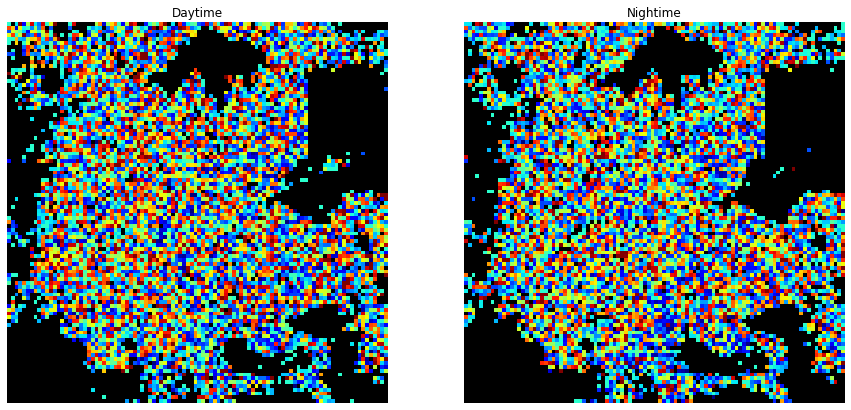

In [32]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(1,2)
ax = fig.add_subplot(gs[0,0])
ax.set_title("Daytime")
mobilkit.viz.shori_density_map(z_score_earthq_mxc_d[0], results_day_mxc["x_bins"], results_day_mxc["y_bins"],
                               ax=ax, vmin=-3, vmax=3)

ax = fig.add_subplot(gs[0,1])
ax.set_title("Nightime")
mobilkit.viz.shori_density_map(z_score_earthq_mxc_n[0], results_night_mxc["x_bins"], results_night_mxc["y_bins"],
                               ax=ax, vmin=-3, vmax=3)

### Zoom in Puebla

In [33]:
center = (19.03, -98.2)
radius = .2
bins = int(500*radius)

In [34]:
results_day_puebla = mobilkit.spatial.stats_density_map(result_density, normaldays, daytime=True,
                                                         bins=bins, center=center, radius=radius)

results_night_puebla = mobilkit.spatial.stats_density_map(result_density, normaldays, daytime=False,
                                                         bins=bins, center=center, radius=radius)

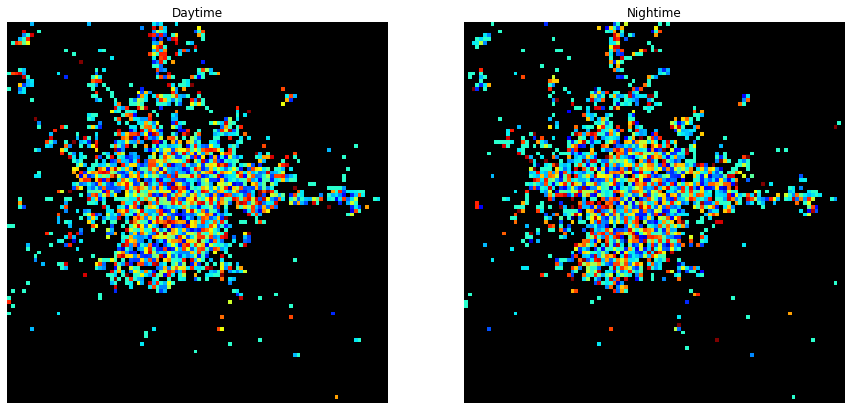

In [35]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(1,2)
ax = fig.add_subplot(gs[0,0])
ax.set_title("Daytime")
mobilkit.viz.shori_density_map(results_day_puebla["zsc"][0],
                               results_day_puebla["x_bins"], results_day_puebla["y_bins"],
                               ax=ax, vmin=-3, vmax=+3)

ax = fig.add_subplot(gs[0,1])
ax.set_title("Nightime")
mobilkit.viz.shori_density_map(results_night_puebla["zsc"][0],
                               results_night_puebla["x_bins"], results_night_puebla["y_bins"],
                               ax=ax, vmin=-3, vmax=+3)

#### Compare day and night

In [42]:
# Compare event day
date_selected = dt(2017, 9, 19)
density_earthquake_puebla_d, xybins_puebla_d = mobilkit.spatial.stack_density_map(result_density, dates=[date_selected],
                                                       center=center, bins=bins, radius=radius)

density_earthquake_puebla_n, xybins_puebla_n = mobilkit.spatial.stack_density_map(result_density, dates=[date_selected],
                                                                            daytime=False, 
                                                                            center=center, bins=bins, radius=radius)

In [43]:
z_score_earthq_puebla_d = (density_earthquake_puebla_d - results_day_puebla["avg"]) / results_day_puebla["std"]
z_score_earthq_puebla_n = (density_earthquake_puebla_n - results_night_puebla["avg"]) / results_night_puebla["std"]

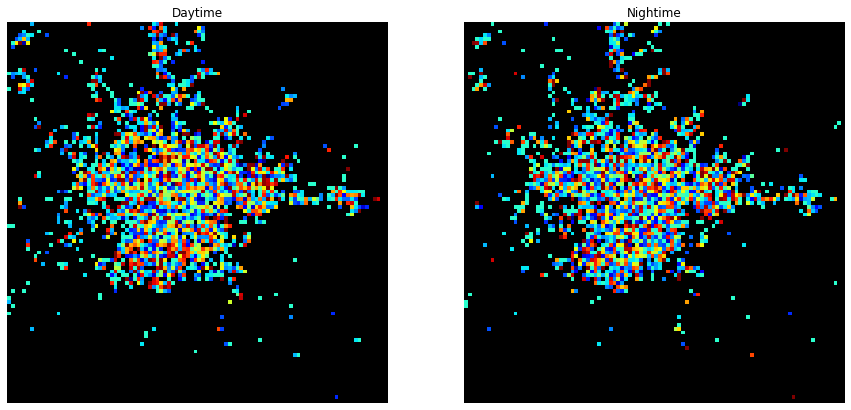

In [44]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(1,2)
ax = fig.add_subplot(gs[0,0])
ax.set_title("Daytime")
mobilkit.viz.shori_density_map(z_score_earthq_puebla_d[0], results_day_puebla["x_bins"], results_day_puebla["y_bins"],
                               ax=ax, vmin=-3, vmax=3)

ax = fig.add_subplot(gs[0,1])
ax.set_title("Nightime")
mobilkit.viz.shori_density_map(z_score_earthq_puebla_n[0], results_night_puebla["x_bins"], results_night_puebla["y_bins"],
                               ax=ax, vmin=-3, vmax=3)